In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


Import Dataset

In [2]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
train_data['text'].shape

(7613,)

In [4]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

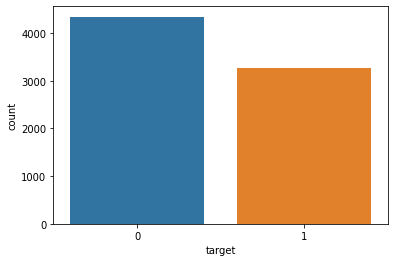

In [5]:
import seaborn as sns

sns.countplot(x = train_data['target'])

In [6]:
X = train_data['text']
y = train_data['target']

Preprocessing

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def clean_text(text):
    text = text.lower()
    word = ' '.join(j for j in text.split() if j not in stop_words)
    return word

X = X.apply(clean_text)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_nw = 75000
max_sl = 160
embedding_dim = 45

tokenizer = Tokenizer(num_words=max_nw,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                    lower=True )
tokenizer.fit_on_texts(X.values)
print("total token:",len(tokenizer.word_index))
print(X[0])

total token: 22666
deeds reason #earthquake may allah forgive us


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=max_sl)
print("shape of tensor:", X.shape,X[0])

test_text = tokenizer.texts_to_sequences(test_data['text'])
test_text = pad_sequences(test_text, maxlen=max_sl)

shape of tensor: (7613, 160) [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 4565
  771  175   67 1527 4566   26]


one-hot encoding

In [10]:
y = pd.get_dummies(y).values
print("shape of label tensor:",y.shape)

shape of label tensor: (7613, 2)


divide data into trainning and validation

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=75)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6471, 160) (6471, 2)
(1142, 160) (1142, 2)


try to use f1 at first as metrics in the dataset.

In [12]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Make model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Embedding,GlobalAveragePooling1D,LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(max_nw,embedding_dim,input_length=X.shape[1]))
model.add(GlobalAveragePooling1D())
model.add(Dense(20,activation="relu"))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

epochs = 30
batch_size = 40
print(batch_size)
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),
                    epochs=epochs,batch_size=batch_size,callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

40
Epoch 1/30
162/162 [==============================] - 7s 38ms/step - loss: 0.6863 - accuracy: 0.5692 - val_loss: 0.6805 - val_accuracy: 0.5683
Epoch 2/30
162/162 [==============================] - 5s 33ms/step - loss: 0.6772 - accuracy: 0.5740 - val_loss: 0.6692 - val_accuracy: 0.5683
Epoch 3/30
162/162 [==============================] - 5s 33ms/step - loss: 0.6569 - accuracy: 0.5832 - val_loss: 0.6079 - val_accuracy: 0.7005
Epoch 4/30
162/162 [==============================] - 6s 35ms/step - loss: 0.5698 - accuracy: 0.7498 - val_loss: 0.5228 - val_accuracy: 0.7688
Epoch 5/30
162/162 [==============================] - 6s 34ms/step - loss: 0.4555 - accuracy: 0.8143 - val_loss: 0.4675 - val_accuracy: 0.8012
Epoch 6/30
162/162 [==============================] - 5s 31ms/step - loss: 0.3565 - accuracy: 0.8674 - val_loss: 0.4384 - val_accuracy: 0.8100
Epoch 7/30
162/162 [==============================] - 5s 33ms/step - loss: 0.2907 - accuracy: 0.9037 - val_loss: 0.4294 - val_accuracy: 0.8

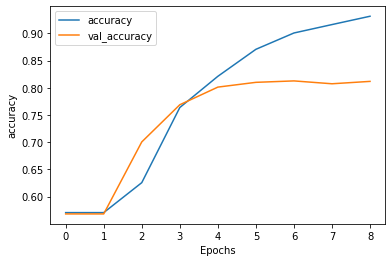

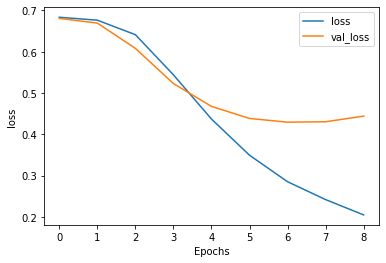

In [14]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [15]:
test_pred  = model.predict(test_text)

prediction = []
for i in range(len(test_pred)):
    if test_pred[i][0] > 0.5:
        prediction.append(0)
    else:
        prediction.append(1)

In [16]:
my_submission = pd.DataFrame({'id': test_data.id, 'target': prediction})

In [17]:
my_submission.to_csv('submission.csv', index=False)